# Aug 22 - Emulate Single Wavelength

GP emulation of 6S for a fixed wavelength.

In [1]:
from typing import Final

import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.gaussian_process as sklearn_gp
import sklearn.pipeline
import sklearn.preprocessing as sklearn_pre
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation


def unit2range(arr: np.ndarray, bot: float, top: float) -> np.ndarray:
    return arr * (top - bot) + bot

## Set wavelength and input parameter ranges

In [2]:
# Fixed wavelength to simulate.
WAVELENGTH: Final = 0.59  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2
AOT_RANGE: Final = (0.05, 0.5)  # 1

# Run true 6S simulation

## Sample atmosphere input ranges

In [3]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 20

# Draw LHS samples.
rng = np.random.default_rng(2023_08_21)
lhs_sampler = sci_qmc.LatinHypercube(d=3, seed=rng)
raw_samples = lhs_sampler.random(NUM_SAMPLES)

# Draw Poisson disk samples
# pd_sampler = sci_qmc.PoissonDisk(d=2, seed=rng, radius=0.18)
# raw_samples = pd_sampler.random(NUM_SAMPLES)
# assert len(raw_samples) == NUM_SAMPLES, "failed to draw enough samples - try decreasing radius"

# Rescale LHS samples to parameter ranges.
ozone_samples = unit2range(raw_samples[:, 0], *OZONE_RANGE)
water_samples = unit2range(raw_samples[:, 1], *WATER_RANGE)
# aot_samples = unit2range(raw_samples[:, 1], *AOT_RANGE)

## Plot atmosphere input samples

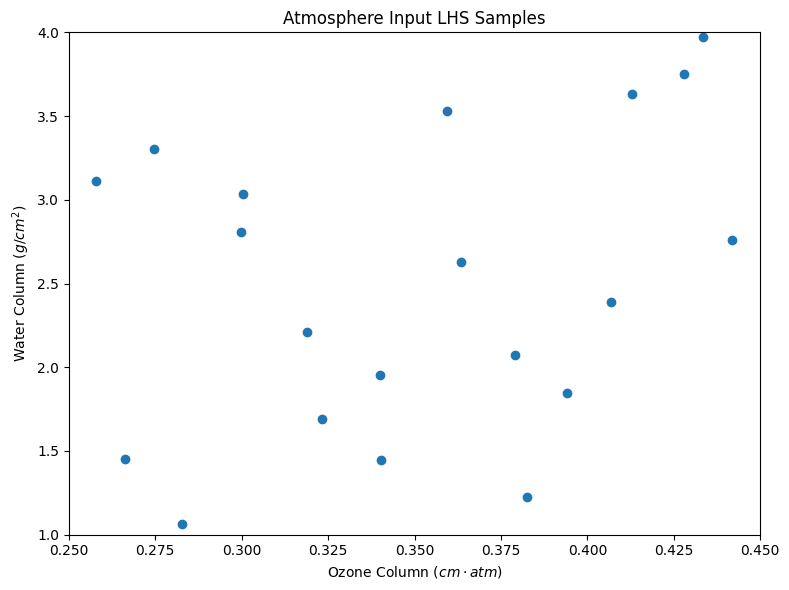

In [4]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# ax.scatter(ozone_samples, water_samples, aot_samples)

fig, ax = plt.subplots(figsize=(8, 6))
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
ax.scatter(ozone_samples, water_samples)
# ax.scatter(ozone_samples, water_samples, aot_samples)
ax.set_xlim(OZONE_RANGE)
ax.set_ylim(WATER_RANGE)
# ax.set_zlim(AOT_RANGE)
ax.set_xlabel("Ozone Column ($cm\cdot atm$)")
ax.set_ylabel("Water Column ($g/cm^2$)")
# ax.set_zlabel("AOT")
ax.set_title("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [5]:
sweep = SweepSimulation(
    {
        "lhs": {
            "atmosphere.ozone": ozone_samples,
            "atmosphere.water": water_samples,
            # "aerosol_profile.aot": aot_samples,
        },
    },
    base=pysixs_default_inputs().replace(
        atmosphere=rtm_param.AtmosphereWaterOzone(),
        # aerosol_profile=rtm_param.AerosolAOTSingleLayer(profile="Maritime", height=5),
        wavelength__value=WAVELENGTH,
    ),
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)

with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

train_results = runner.collect_results()
train_output = train_results.apparent_radiance

display(train_results)

|████████████████████████████████████████| 20/20 [100%] in 0.2s (99.24/s)       


<xarray.Dataset>
Dimensions:                        (lhs: 20)
Coordinates:
  * lhs                            (lhs) int64 0 1 2 3 4 5 ... 14 15 16 17 18 19
    atmosphere.ozone               (lhs) float64 0.3189 0.3824 ... 0.2577 0.2827
    atmosphere.water               (lhs) float64 2.209 1.227 ... 3.115 1.067
Data variables:
    transmittance_diffuse_down     (lhs) float64 0.3857 0.3857 ... 0.3857 0.3857
    transmittance_scattering_up    (lhs) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    apparent_radiance              (lhs) float64 114.9 118.0 ... 112.5 120.2
    transmittance_direct_up        (lhs) float64 0.5416 0.5416 ... 0.5416 0.5416
    transmittance_diffuse_up       (lhs) float64 0.4584 0.4584 ... 0.4584 0.4584
    transmittance_scattering_down  (lhs) float64 0.8996 0.8996 ... 0.8996 0.8996
    transmittance_direct_down      (lhs) float64 0.5139 0.5139 ... 0.5139 0.5139
Attributes:
    version:     0.2.0.dev0+276d3e8
    platform:    CPython 3.10.12 (Linux atricapillus 6.2.0-26-generic #26~22....
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(altitude_target=AltitudePredefined(name='sealevel'), ...
    base_pzb64:  H4sIANUU6GQC/22QX0rDQBDGFTQGWlCkiEdQkL54AOmLUVAsQunjMmkmycL+...
    sim_start:   2023-08-24T22:41:25.797903-04:00
    sim_end:     2023-08-24T22:41:25.964385-04:00

## Plot scatter of outputs at each input

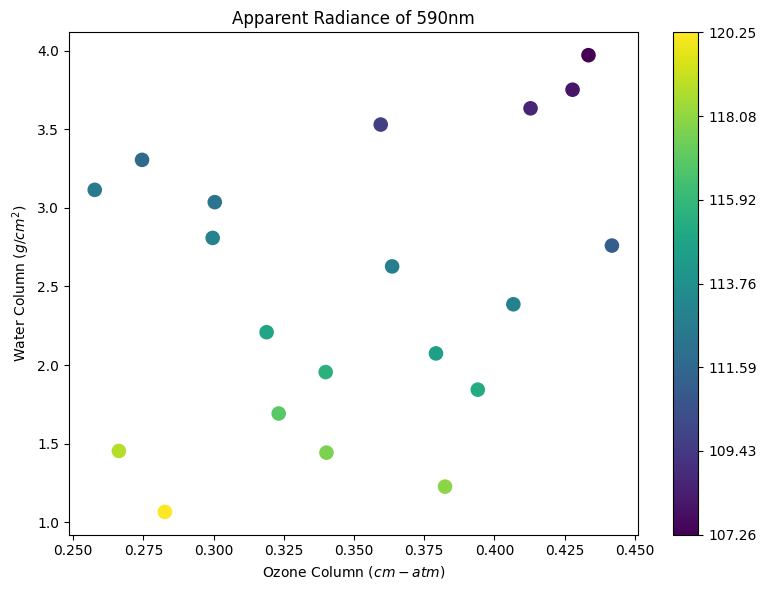

In [6]:
color_source = train_output.values
color = (color_source - color_source.min()) / (color_source.max() - color_source.min())

# fig, ax =  plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# art = ax.scatter(
#     train_results.coords["atmosphere.ozone"].values,
#     train_results.coords["atmosphere.water"].values,
#     train_results.coords["aerosol_profile.aot"].values,
#     c=color,
#     s=90,
#     cmap="viridis",
# )
fig, ax = plt.subplots(figsize=(8, 6))
art = ax.scatter(
    train_results.coords["atmosphere.ozone"].values,
    train_results.coords["atmosphere.water"].values,
    c=color,
    s=90,
    cmap="viridis",
)
n_ticks = 7
cbar = fig.colorbar(art, ticks=np.linspace(0, 1, n_ticks))
cbar.ax.set_yticklabels(
    np.round(np.linspace(color_source.min(), color_source.max(), n_ticks), 2)
)
ax.set_title(f"Apparent Radiance of {WAVELENGTH*1000:.0f}nm")
ax.set_xlabel("Ozone Column ($cm-atm$)")
ax.set_ylabel("Water Column ($g/cm^2$)")
fig.tight_layout()

# Train Emulator

## Extract training arrays

In [7]:
x_train = np.stack(
    [
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
        # train_results.coords["aerosol_profile.aot"].values,
    ],
    axis=-1,
)
y_train = train_output.values.reshape(-1, 1)
print(f"{x_train.shape=}, {y_train.shape=}")

x_train.shape=(20, 2), y_train.shape=(20, 1)


## Create GP model

In [8]:
kernel = 1.0 * sklearn_gp.kernels.RBF() # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = sklearn_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-2,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        ("scale", sklearn_pre.MinMaxScaler()),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('gp',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=20,
                                          normalize_y=True))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

## Fit model

In [9]:
pipeline.fit(x_train, y_train)
display(pipeline.named_steps["gp"].kernel_)

5.33**2 * RBF(length_scale=3.32)

## Plot marginal likelihood surface

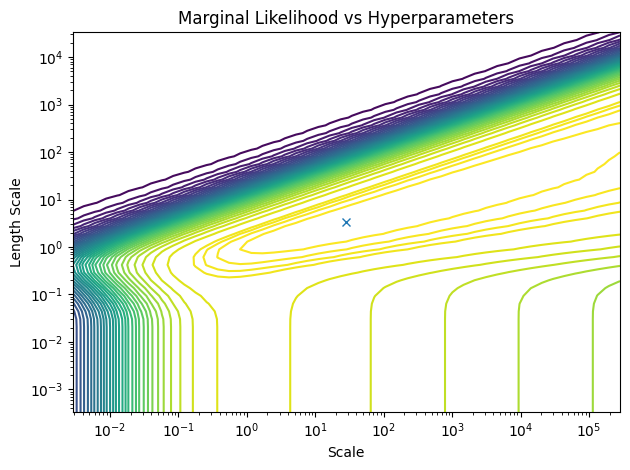

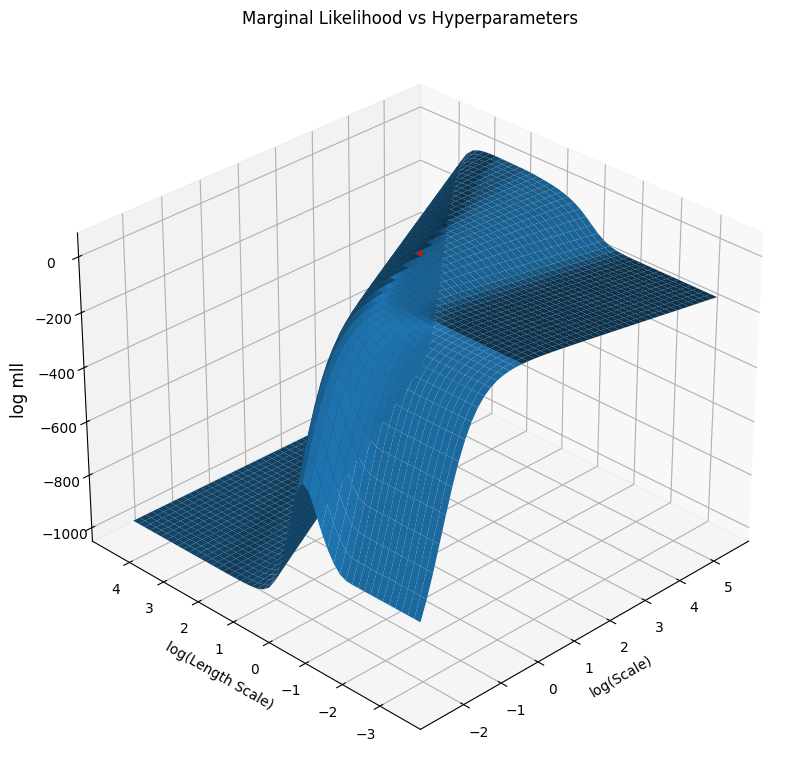

In [10]:
fit_theta = pipeline.named_steps["gp"].kernel_.theta

# Range of hyperparameter to compute marginal likelihood over.
# Natural log scaled, and centered about fit hyperparameter values found above.
log_scale_range = np.log(10) * np.linspace(-4, 4, 50) + fit_theta[0]
log_length_range = np.log(10) * np.linspace(-4, 4, 50) + fit_theta[1]


mesh_scale, mesh_length = np.meshgrid(log_scale_range, log_length_range)
# Preallocate array for likelihood at each hyperparameter combination.
log_marginal_likelihoods = np.zeros(mesh_scale.shape)

for scale, length, out in np.nditer(
    [mesh_scale, mesh_length, log_marginal_likelihoods],
    op_flags=[["readonly"], ["readonly"], ["writeonly"]],
):
    theta = [scale, length]
    out[...] = gaussian_process.log_marginal_likelihood(theta)

fig, ax = plt.subplots()

ax.set_xscale("log")
ax.set_yscale("log")
# Pick contour levels. Increase level density near max to better show peaks.
peak_switch = np.percentile(log_marginal_likelihoods, 85)
levels = np.hstack(
    (
        np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
        np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
    )
)
# levels = 30
art = ax.contour(
    np.exp(mesh_scale), np.exp(mesh_length), log_marginal_likelihoods, levels
)
ax.plot(*np.exp(fit_theta), "x")
ax.set_xlabel("Scale")
ax.set_ylabel("Length Scale")
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
ax.computed_zorder = False  # Prevent surface from hiding point, https://stackoverflow.com/q/51241367/11082165
ax.view_init(elev=30, azim=-135)
zlims = ax.get_zlim()
ax.scatter(
    [fit_theta[0] / np.log(10)],
    [fit_theta[1] / np.log(10)],
    [gaussian_process.log_marginal_likelihood(fit_theta)],
    c="r",
    s=5,
    zorder=2,
)
ax.plot_surface(
    mesh_scale / np.log(10),
    mesh_length / np.log(10),
    log_marginal_likelihoods,
    zorder=1,
)

ax.set_xlabel("log(Scale)")
ax.set_ylabel("log(Length Scale)")
fig.supylabel("log mll")
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

# Asses Emulator

## Generate test data

In [11]:
ozone_test = np.linspace(*OZONE_RANGE, 30)
water_test = np.linspace(*WATER_RANGE, 31)

## Obtain actual sim results for test data

In [12]:
sweep = SweepSimulation(
    {
        "atmosphere.ozone": ozone_test,
        "atmosphere.water": water_test,
    },
    base=pysixs_default_inputs().replace(
        atmosphere=rtm_param.AtmosphereWaterOzone(),
        wavelength__value=WAVELENGTH,
    ),
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)
with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

test_results = runner.collect_results()
test_output = test_results.apparent_radiance

display(test_output)

|████████████████████████████████████████| 930/930 [100%] in 6.9s (135.60/s)    


<xarray.DataArray 'apparent_radiance' (atmosphere.ozone: 30,
                                       atmosphere.water: 31)>
array([[121.073, 120.612, 120.158, 119.712, 119.272, 118.84 , 118.414,
        117.995, 117.582, 117.175, 116.774, 116.379, 115.989, 115.605,
        115.226, 114.853, 114.484, 114.12 , 113.761, 113.407, 113.057,
        112.712, 112.37 , 112.033, 111.701, 111.372, 111.047, 110.726,
        110.408, 110.095, 109.784],
       [120.964, 120.503, 120.05 , 119.604, 119.165, 118.732, 118.307,
        117.888, 117.476, 117.069, 116.668, 116.274, 115.884, 115.501,
        115.122, 114.749, 114.38 , 114.017, 113.658, 113.304, 112.955,
        112.61 , 112.269, 111.932, 111.6  , 111.271, 110.947, 110.626,
        110.309, 109.995, 109.685],
       [120.855, 120.394, 119.941, 119.495, 119.057, 118.625, 118.2  ,
        117.782, 117.369, 116.963, 116.563, 116.169, 115.78 , 115.396,
        115.018, 114.645, 114.277, 113.914, 113.556, 113.202, 112.853,
        112.508, 112.167, 111.831, 111.499, 111.171, 110.846, 110.526,
        110.209, 109.896, 109.586],
       [120.745, 120.285, 119.833, 119.387, 118.949, 118.518, 118.093,
        117.675, 117.263, 116.858, 116.458, 116.064, 115.675, 115.292,
        114.914, 114.542, 114.174, 113.811, 113.453, 113.1  , 112.751,
        112.406, 112.066, 111.73 , 111.398, 111.07 , 110.746, 110.426,
        110.109, 109.796, 109.487],
...
       [118.261, 117.81 , 117.367, 116.931, 116.502, 116.08 , 115.664,
        115.254, 114.851, 114.453, 114.062, 113.676, 113.295, 112.92 ,
        112.55 , 112.185, 111.825, 111.469, 111.119, 110.773, 110.431,
        110.094, 109.76 , 109.431, 109.106, 108.785, 108.468, 108.154,
        107.844, 107.537, 107.234],
       [118.154, 117.704, 117.261, 116.825, 116.397, 115.975, 115.559,
        115.15 , 114.747, 114.35 , 113.959, 113.573, 113.193, 112.818,
        112.448, 112.084, 111.724, 111.369, 111.018, 110.673, 110.331,
        109.994, 109.661, 109.332, 109.008, 108.687, 108.37 , 108.056,
        107.746, 107.44 , 107.138],
       [118.048, 117.598, 117.155, 116.72 , 116.292, 115.87 , 115.455,
        115.046, 114.643, 114.247, 113.856, 113.47 , 113.09 , 112.716,
        112.347, 111.982, 111.623, 111.268, 110.918, 110.573, 110.232,
        109.895, 109.562, 109.234, 108.909, 108.588, 108.272, 107.959,
        107.649, 107.343, 107.041],
       [117.941, 117.491, 117.049, 116.614, 116.186, 115.765, 115.35 ,
        114.942, 114.54 , 114.143, 113.753, 113.368, 112.988, 112.614,
        112.245, 111.881, 111.522, 111.168, 110.818, 110.473, 110.132,
        109.795, 109.463, 109.135, 108.811, 108.49 , 108.174, 107.861,
        107.552, 107.246, 106.944]])
Coordinates:
  * atmosphere.ozone  (atmosphere.ozone) float64 0.25 0.2569 ... 0.4431 0.45
  * atmosphere.water  (atmosphere.water) float64 1.0 1.1 1.2 1.3 ... 3.8 3.9 4.0
Attributes:
    title:    Apparent Radiance
    unit:     W/sr-m^2

## Extract test arrays

In [13]:
mesh_ozone, mesh_water = np.meshgrid(
    test_results.coords["atmosphere.ozone"].values,
    test_results.coords["atmosphere.water"].values,
    indexing="ij",
)

x_test = np.hstack((mesh_ozone.reshape(-1, 1), mesh_water.reshape(-1, 1)))
y_test = test_output.values.reshape(-1, 1)

print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=(930, 2), y_test.shape=(930, 1)


## Evaluate model on test data

In [14]:
pred_mean, pred_std = pipeline.predict(x_test, return_std=True)
pred_error = y_test - pred_mean.reshape(-1, 1)

pred_mean = pred_mean.reshape(mesh_ozone.shape)
pred_std = pred_std.reshape(mesh_ozone.shape)
pred_error = pred_error.reshape(mesh_ozone.shape)
y_test_shaped = y_test.reshape(mesh_ozone.shape)

## Compute metrics

In [15]:
rmse = np.sqrt(np.mean(pred_error**2))

abs_error = np.abs(pred_error)

print(f"RMSE: {rmse:0.2f}")
print(f"Avg abs err: {np.mean(abs_error):0.2f}")
print(f"Max abs err: {np.max(abs_error):0.2f}")
print(f"Avg rel err: {np.mean(abs_error/y_test_shaped):0.2%}")
print(f"Max rel err: {np.max(abs_error/y_test_shaped):0.2%}")

RMSE: 0.10
Avg abs err: 0.08
Max abs err: 0.40
Avg rel err: 0.07%
Max rel err: 0.34%


## Plot posterior mean, std, error

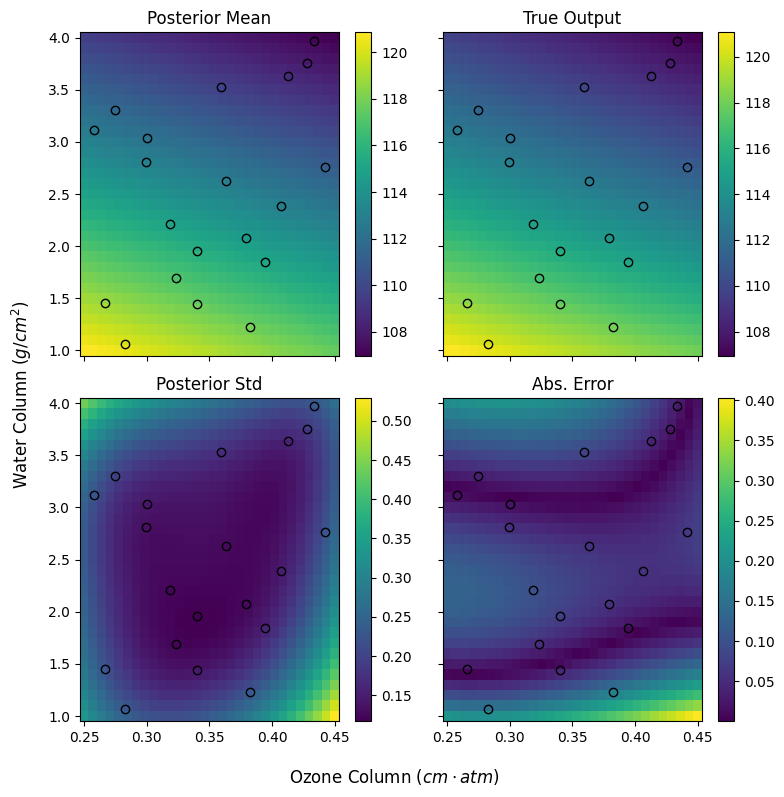

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex="all", sharey="all")

mesh_ozone, mesh_water = np.meshgrid(ozone_test, water_test, indexing="ij")

# Plot predicted mean surface.
ax = axs[0, 0]
art = ax.pcolormesh(mesh_ozone, mesh_water, pred_mean)
ax.plot(
    train_results.coords["atmosphere.ozone"].values,
    train_results.coords["atmosphere.water"].values,
    "o",
    color="k",
    markerfacecolor="none",
)
ax.set_title("Posterior Mean")
cbar = fig.colorbar(art)

# Plot true output surface.
ax = axs[0, 1]
art = ax.pcolormesh(mesh_ozone, mesh_water, y_test_shaped)
ax.plot(
    train_results.coords["atmosphere.ozone"].values,
    train_results.coords["atmosphere.water"].values,
    "o",
    color="k",
    markerfacecolor="none",
)
ax.set_title("True Output")
fig.colorbar(art)

# Plot predicted variance surface.
ax = axs[1, 0]
art = ax.pcolormesh(mesh_ozone, mesh_water, pred_std)
ax.plot(
    train_results.coords["atmosphere.ozone"].values,
    train_results.coords["atmosphere.water"].values,
    "o",
    color="k",
    markerfacecolor="none",
)
ax.set_title("Posterior Std")
fig.colorbar(art)

# Plot error surface.
ax = axs[1, 1]
art = ax.pcolormesh(mesh_ozone, mesh_water, np.abs(pred_error))
ax.plot(
    train_results.coords["atmosphere.ozone"].values,
    train_results.coords["atmosphere.water"].values,
    "o",
    color="k",
    markerfacecolor="none",
)
ax.set_title("Abs. Error")
fig.colorbar(art)

fig.supxlabel("Ozone Column ($cm\cdot atm$)")
fig.supylabel("Water Column ($g/cm^2$)")

fig.tight_layout()